## **Dimensionality Reduction for Functional Data** ##

In several scenarios, we may be dealing with functional data. That is the data could be sampled from a multi-dimensional space, and in some cases the number of dimensions could be very huge and may contain redundant information. 

Gaussian Processes(GPs) do not scale very well to high-dimensional data. `twinLab` provides the functionality to perform dimensionality reduction on the data, truncate the number of dimensions and train GPs effectively.

This notebook will cover:

1. How to perform dimensionality reduction on both input features and output features of the dataset



Import the necessary libraries

In [ ]:
# system imports
import os

# Third party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product

# twinLab import
import twinlab as tl

Read the train and test dataframes from the respective CSV files. Since the output is functional, the grid file contains data about the values at which these functions are evaluated.

The dataset contains datapoints with 5 input dimensions and 624 output dimensions. The number of output dimensions is huge and it might be better to train our emulators on truncated outputs for efficient and effective training.

In [2]:
data_path = os.path.join("resources", "datasets", "ukaea_small.csv")
test_data_path = os.path.join("resources", "datasets", "test.csv")
grid_path = os.path.join("resources", "datasets", "grid.csv")
df_train = pd.read_csv(data_path)
df_eval = pd.read_csv(test_data_path)
df_grid = pd.read_csv(grid_path, header=None)

input_columns = ["E1", "E2", "E3", "n1", "n2"]
output_columns = [f"y{i}" for i in range(0, df_train.shape[1]-len(input_columns))]

Define a `Dataset` object and upload it to the twinLab cloud

In [ ]:
# Define the name of the dataset
dataset_id = "Tritium_Desorption_Data"

# Intialise a Dataset object
dataset = tl.Dataset(id=dataset_id)

# Upload the dataset
dataset.upload(df_train, verbose=True)

## **Dimensionality Reduction** ##

In `twinlab`, dimensionality reduction is implemented in the form of truncated Singular Value Decomposition (tSVD), and is accessible in two ways. It can be performed by specifiying the number of dimensions we want to truncate the data to, using `input_retained_dimensions` for inputs and `output_retained_dimensions` for outputs. This can also be specified through the amount of variance to be explained by the data after truncation through `input_explained_variance` for inputs and `output_explained_variance` for outputs. These parameters are part of the `TrainParams` object, and can then be further passed to the training function `Emulator.train`.

One can decompose the inputs, outputs, or both in the same `Emulator`.

We initially train an emulator by truncating the number of output dimensions to 2 (from 624!).

In [ ]:
# Initialise emulator
emulator_id = "TritiumDesorptionGP"

emulator = tl.Emulator(id=emulator_id)

# Define the training parameters for your emulator
params = tl.TrainParams(
    train_test_ratio=0.80,
    estimator="gaussian_process_regression",
    output_retained_dimensions=2,
)

# Train the emulator using the train method
emulator.train(
    dataset=dataset,
    inputs=input_columns,
    outputs=output_columns,
    params=params,
    verbose=True,
)

# Predict the results
predictions = emulator.predict(df_eval)
result_df = pd.concat([predictions[0], predictions[1]], axis=1)
df_mean, df_std = result_df.iloc[:,:len(output_columns)], result_df.iloc[:,len(output_columns):]

Let's now try and train a new emulator with slightly increased number of dimensions but still significantly lesser than the original number of output dimensions. We will now train a new emulator with only 6 dimensions.

In [ ]:
# Initialise emulator
emulator_id = "TritiumDesorptionGP_new"

new_emulator = tl.Emulator(id=emulator_id)

# Define the training parameters for your emulator
params = tl.TrainParams(
    train_test_ratio=0.80,
    estimator="gaussian_process_regression",
    output_retained_dimensions=6,
)

# Train the emulator using the train method
new_emulator.train(
    dataset=dataset,
    inputs=input_columns,
    outputs=output_columns,
    params=params,
    verbose=True,
)

# Predict the results
predictions1 = new_emulator.predict(df_eval)
result_df1 = pd.concat([predictions1[0], predictions1[1]], axis=1)
df_mean1, df_std1 = result_df1.iloc[:,:len(output_columns)], result_df1.iloc[:,len(output_columns):]

We define a function to plot the predictions of the 2 trained emulators with different output dimensions alongside the true values from the test data.

In [48]:
def plot_predictions(df_mean, df_mean1, df_std, df_std1, df_grid, output_columns):
# Parameters for plot
    error_inflation_factor = 1. # Factor to multiply error by for plotting
    y_fac = 18 # Factor to divide y by for plotting [log10]
    plot_eval = True
    data_alpha = 0.75
    plot_model_mean = True
    plot_model_bands = True
    plot_model_blur = False
    nsigs = [1, 2]
    model_alpha = 0.5
    model_color_1 = 'red'
    model_color_2 = 'green'
    number_of_model_examples = 5
    iter = 0

    # Plot results
    grid = df_grid.iloc[:, 0]
    fig, axs = plt.subplots(1, number_of_model_examples, figsize=(30, 5))
    if (plot_model_blur or plot_model_bands) and not plot_model_mean: 
        axs[iter].fill_between(grid, np.nan, np.nan, color=model_color_1, alpha=model_alpha, lw=0., label="Model 1")
        axs[iter].fill_between(grid, np.nan, np.nan, color=model_color_2, alpha=model_alpha, lw=0., label="Model 2")
    for example in range(number_of_model_examples): # Model predictions
        mean = df_mean[output_columns].iloc[example]/10**y_fac
        err = error_inflation_factor*df_std[output_columns].iloc[example]/10**y_fac
        mean1 = df_mean1[output_columns].iloc[example]/10**y_fac
        err1 = error_inflation_factor*df_std1[output_columns].iloc[example]/10**y_fac
        if plot_eval:
            eval = df_eval[output_columns].iloc[example]/10**y_fac
            label = "Test data" if example==0 else None
            axs[iter].plot(grid, eval, color='black', alpha=data_alpha, label=label)
        if plot_model_bands:
            for isig, nsig in enumerate(nsigs):
                label = "Model 1" if (isig == 0) and (example == 0) else None
                label1 = "Model 2" if (isig == 0) and (example == 0) else None
                axs[iter].fill_between(grid, mean-nsig*err, mean+nsig*err, color=model_color_1, alpha=model_alpha/(isig+1), lw=0., label=label)
                axs[iter].fill_between(grid, mean1-nsig*err1, mean1+nsig*err1, color=model_color_2, alpha=model_alpha/(isig+1), lw=0., label=label1)
        if plot_model_mean:
            label = "Model 1" if (example==0) and (not plot_model_bands) and (not plot_model_blur) else None
            label1 = "Model 2" if (example==0) and (not plot_model_bands) and (not plot_model_blur) else None
            axs[iter].plot(grid, mean, color=model_color_1, label=label, alpha=model_alpha)
            axs[iter].plot(grid, mean1, color=model_color_2, label=label1, alpha=model_alpha)
        axs[iter].set_xlabel(r'Temperature [K]')
        axs[iter].set_ylabel(rf"Desorption rate [$10^{{{y_fac}}}$ $m^{{{-2}}}$ $s^{{{-1}}}$]")
        axs[iter].legend(['Test Data', 'Model 1', 'Model 2'])
        iter += 1
    plt.show()

Plot the predictions for both the emulators. It can be observed that the first emulator trained with very low output dimensions fails to approximate the data properly. This can be attributed to the massive truncation of the output dimensions. 

The second emulator was trained on 6 output dimensions. It is definitely more than the first emulator, but is still significantly lower than the originial number of dimensions. With this emulator we seem to have struck the right balance. 

The predictions are very accurate! We reduced the number of output dimensions from 624 to 6 and still managed to train a very good surrogate of the underlying functional data. 

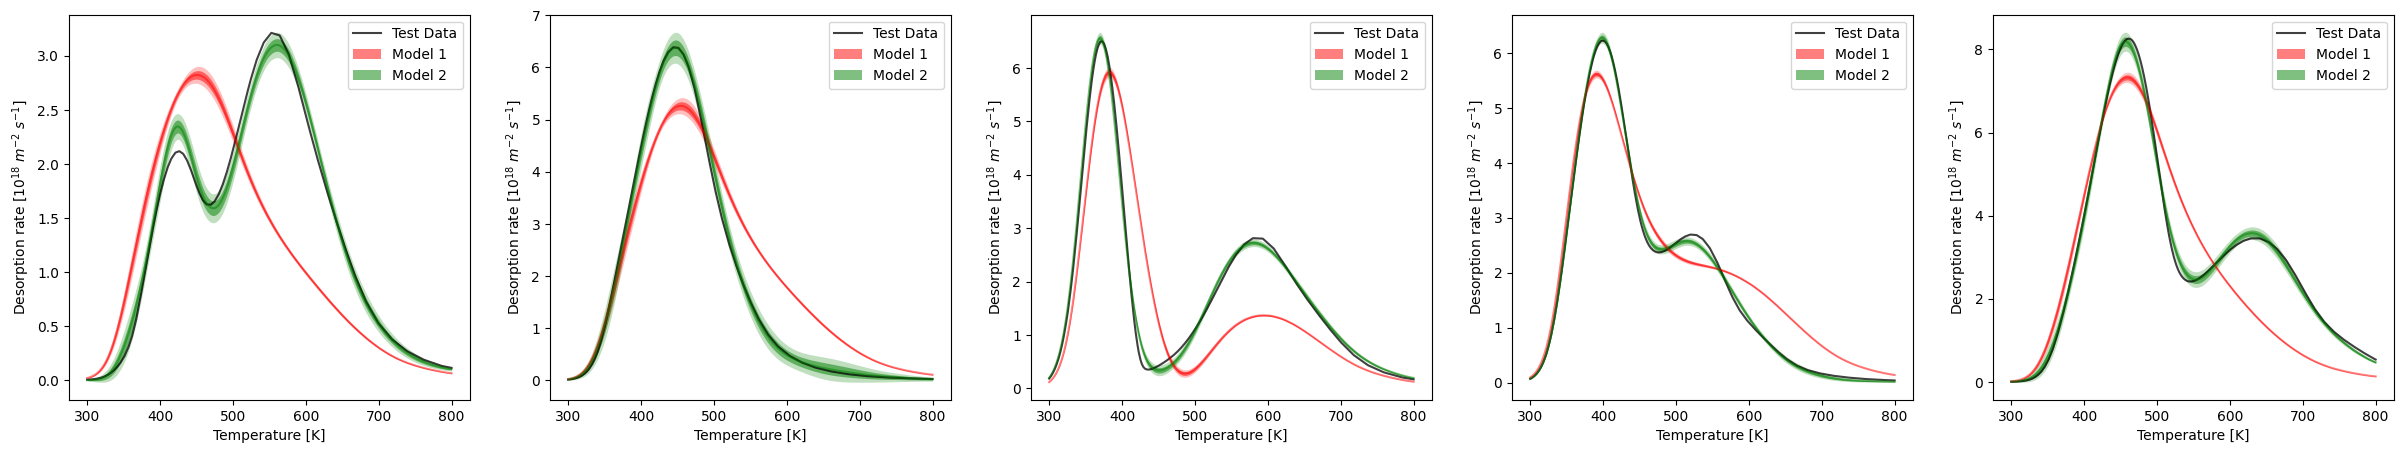

In [49]:
plot_predictions(df_mean, df_mean1, df_std, df_std1, df_grid, output_columns)

This highlights the importance of dimesionality reduction in data processing and this is achieved in `twinLab` by just specifying a few parameters namely, `input_retained_dimensions` or `input_explained_variance` for inputs and `output_retained_dimensions` or `output_explained_variance` for outputs.